## SmartStream Demo  - Detecting EVM OK or Alert and Person in an image

In [1]:
# setup libraries
import boto3
import io
from PIL import Image, ImageDraw, ExifTags, ImageColor, ImageFont
from IPython.display import HTML, display, Image as IImage

client=boto3.client('rekognition')
s3 = boto3.client('s3')
s3_connection = boto3.resource('s3')

# setup
bucket='rekognitioncustomlabels-pvt'

# Sample test images
#photo = "Screenshot (6).png" # EVM OK - no voter
photo = "Screenshot (233).png" # EVM alert 
#photo = "Screenshot (27).png" # EVM OK - 1 voter

display(IImage(url=s3.generate_presigned_url('get_object', Params={'Bucket': bucket, 'Key': photo})))

---
## Start the model

In [2]:
#Copyright 2020 Amazon.com, Inc. or its affiliates. All Rights Reserved.
#PDX-License-Identifier: MIT-0 (For details, see https://github.com/awsdocs/amazon-rekognition-custom-labels-developer-guide/blob/master/LICENSE-SAMPLECODE.)

import boto3

def start_model(project_arn, model_arn, version_name, min_inference_units):

    client=boto3.client('rekognition')

    try:
        # Start the model
        print('Starting model: ' + model_arn)
        response=client.start_project_version(ProjectVersionArn=model_arn, MinInferenceUnits=min_inference_units)
        # Wait for the model to be in the running state
        project_version_running_waiter = client.get_waiter('project_version_running')
        project_version_running_waiter.wait(ProjectArn=project_arn, VersionNames=[version_name])

        #Get the running status
        describe_response=client.describe_project_versions(ProjectArn=project_arn,
            VersionNames=[version_name])
        for model in describe_response['ProjectVersionDescriptions']:
            print("Status: " + model['Status'])
            print("Message: " + model['StatusMessage']) 
    except Exception as e:
        print(e)
        
    print('Done...')
    
def main():
    project_arn='arn:aws:rekognition:us-west-2:406078665760:project/SmartStream-evm-custom-label-Dec2021/1640107420943'
    model_arn='arn:aws:rekognition:us-west-2:406078665760:project/SmartStream-evm-custom-label-Dec2021/version/SmartStream-evm-custom-label-Dec2021.2021-12-21T13.46.11/1640119571232'
    min_inference_units=1 
    version_name='SmartStream-evm-custom-label-Dec2021.2021-12-21T13.46.11'
    start_model(project_arn, model_arn, version_name, min_inference_units)

if __name__ == "__main__":
    main()

Starting model: arn:aws:rekognition:us-west-2:406078665760:project/SmartStream-evm-custom-label-Dec2021/version/SmartStream-evm-custom-label-Dec2021.2021-12-21T13.46.11/1640119571232
Status: RUNNING
Message: The model is running.
Done...


---
### Detected an EVM and identify evm_ok or evm_alert in the test image


In [3]:
# detect EVM OK or Alert
def display_image(bucket,img,response):
    # Load image from S3 bucket

    s3_object = s3_connection.Object(bucket,img)
    s3_response = s3_object.get()

    stream = io.BytesIO(s3_response['Body'].read())
    image=Image.open(stream)

    # Ready image to draw bounding boxes on it.
    imgWidth, imgHeight = image.size
    draw = ImageDraw.Draw(image)
    
  
    # calculate and display bounding boxes for each detected custom label
    for customLabel in response['CustomLabels']:
 
        if 'Geometry' in customLabel:
            box = customLabel['Geometry']['BoundingBox']
            left = imgWidth * box['Left']
            top = imgHeight * box['Top']
            width = imgWidth * box['Width']
            height = imgHeight * box['Height']

            # fnt = ImageFont.load_default() works
            fnt = ImageFont.truetype("/usr/share/fonts/dejavu/DejaVuSans-Bold.ttf", 35)
            # use red for alert and blue for ok
            if (customLabel['Name'] == "evm_alert"):
                fontColor = "red"
            else:
                fontColor = "blue"
                
            draw.text((left,top), customLabel['Name'], fontColor, font=fnt)

            points = (
                (left,top),
                (left + width, top),
                (left + width, top + height),
                (left , top + height),
                (left, top))
            draw.line(points, fill='#00d400', width=5)

    image.show()

def show_custom_labels(model,bucket,img, min_confidence):
 

    # Call DetectCustomLabels
    response = client.detect_custom_labels(Image={'S3Object': {'Bucket': bucket, 'Name': img}},
        MinConfidence=min_confidence,
        ProjectVersionArn=model)


    
    # display image.
    display_image(bucket,img,response)

    #return len(response['CustomLabels'])
    return (response['CustomLabels'])

# using the latest Rekognition Custom Model with F1 score = 0.850, Average precision = 0.895 and Overall recall = 0.810
# trained custom label on Dec 21, 2021
def main():
# old model    model='arn:aws:rekognition:us-west-2:406078665760:project/evm-identification-ver3/version/evm-identification-ver3.2021-12-02T18.13.54/1638494035178'
    model='arn:aws:rekognition:us-west-2:406078665760:project/SmartStream-evm-custom-label-Dec2021/version/SmartStream-evm-custom-label-Dec2021.2021-12-21T13.46.11/1640119571232'

    min_confidence=70

    labels=show_custom_labels(model,bucket, photo, min_confidence)
    print("evm = "+str(labels[0]['Name']))
    print("confidence = "+str(labels[0]['Confidence']))

if __name__ == "__main__":
    main()

evm = evm_alert
confidence = 98.77399444580078


---
### Detect number of Person in the Polling room with image coming from internal camera

In [4]:
# Detect the number of Person in the image

def countPeople(img, confidence_Level):
    detectLabelsResponse = client.detect_labels(
        Image={
            'S3Object': {
                'Bucket': bucket,
                'Name': img,
            }
        }
    )
    # We want to count the Person in the room
    flaggedObjects = ["Person"]

    responseMetaData = detectLabelsResponse['ResponseMetadata']
    responseHTTPHeader = responseMetaData['HTTPHeaders']
    date = responseHTTPHeader['date']
    # detectLabelsResponse
    # You can set a mininum confidence threshold level
    min_confidence = confidence_Level

    for label in detectLabelsResponse["Labels"]:
        if(label["Name"] in flaggedObjects):
            count = len(label["Instances"])
            peopleCount = 0
            for instance in label['Instances']:
                confidence = instance['Confidence']
                if confidence > min_confidence:
                    peopleCount = peopleCount + 1
   
    return(peopleCount)

In [5]:
# display the person in the image
minConfidence = 70
number = countPeople(photo, minConfidence)
print("Number of persons identified = "+str(number)+" with confidence level above = "+str(minConfidence)+"%")

Number of persons identified = 3 with confidence level above = 70%


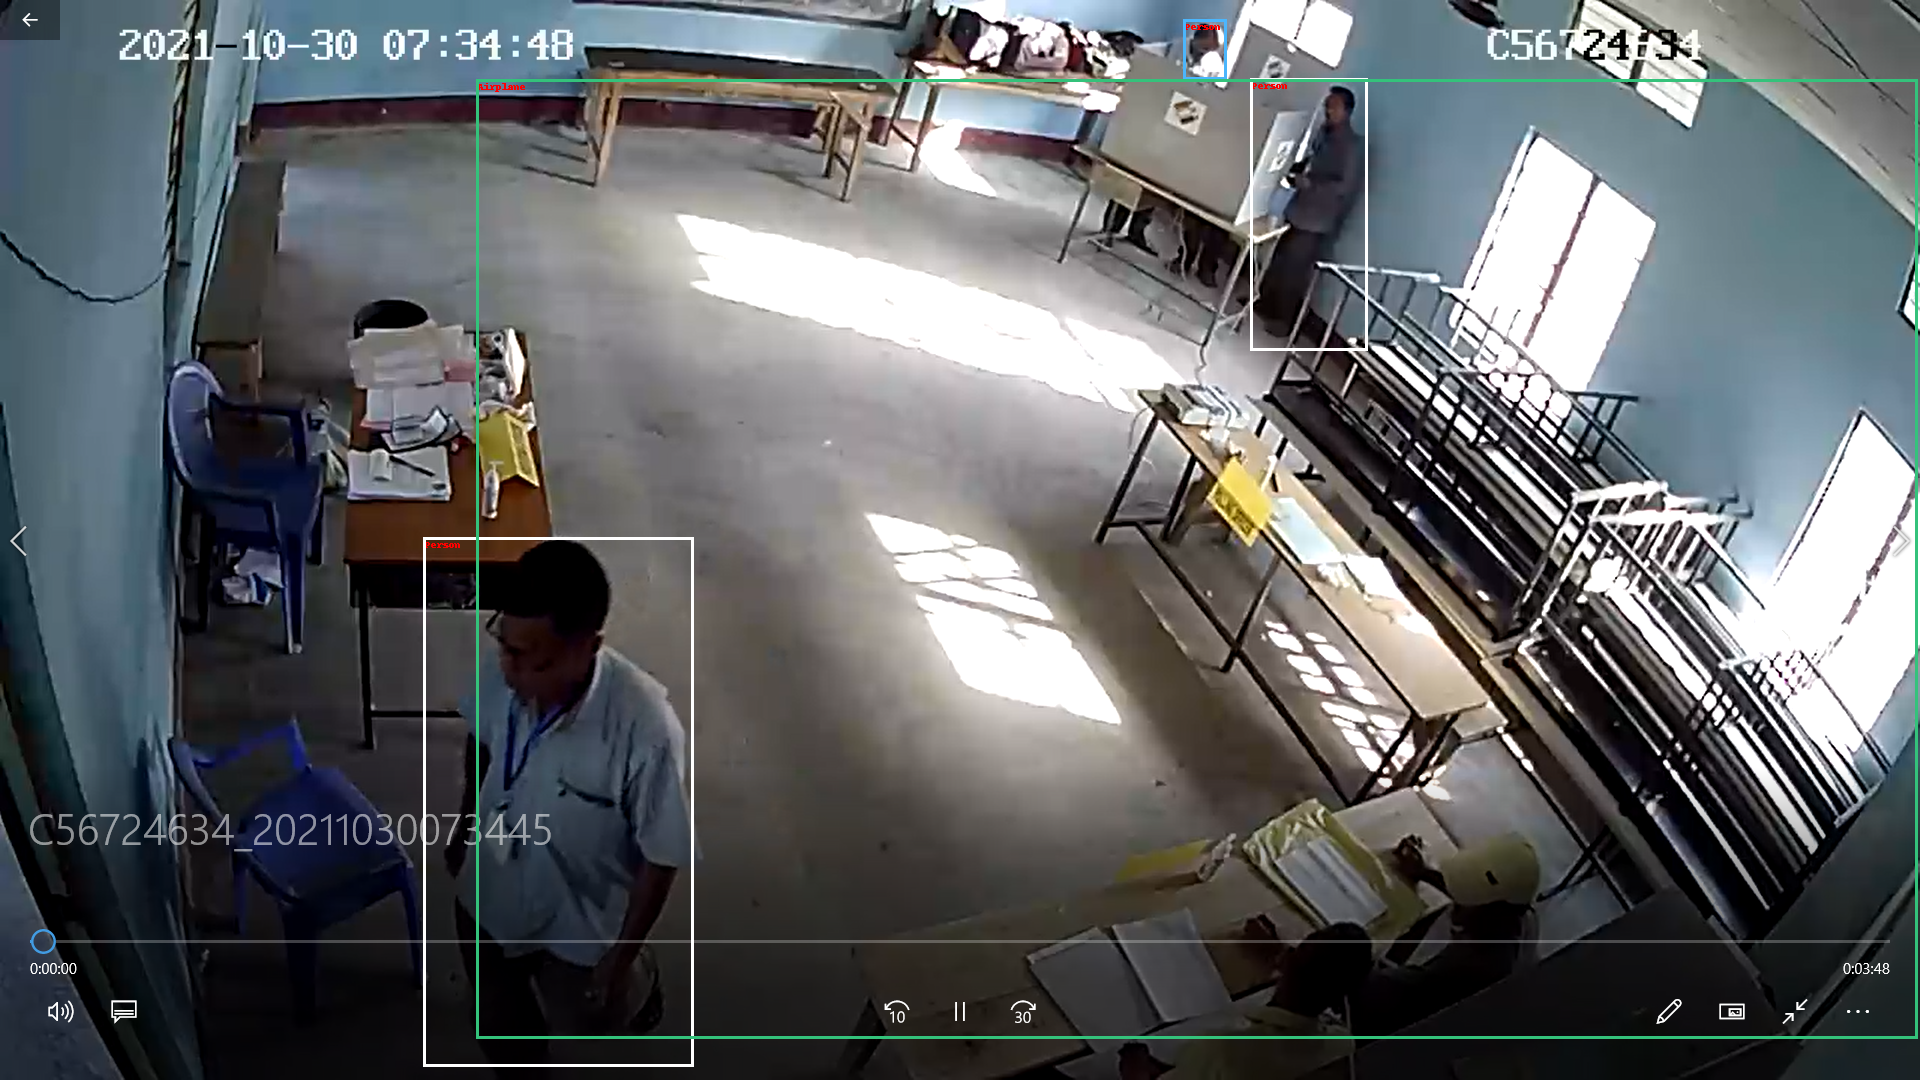

In [6]:
# Define a function that will display image with bounded boxes around recognized objects
# 
tempfolder='mytmp1'

def drawBoundingBoxes (sourceImage, boxes):
    # blue, green, red, grey
    colors = ((255,255,255),(255,255,255),(76,182,252),(52,194,123))
   
    # Download image locally
    imageLocation = tempfolder+'/'+sourceImage
    
    s3.download_file(bucket, sourceImage, imageLocation)

    # Draws BB on Image
    bbImage = Image.open(imageLocation)
    draw = ImageDraw.Draw(bbImage)
    width, height = bbImage.size
    col = 0
    maxcol = len(colors)
    line= 3
    for box in boxes:
        x1 = int(box[1]['Left'] * width)
        y1 = int(box[1]['Top'] * height)
        x2 = int(box[1]['Left'] * width + box[1]['Width'] * width)
        y2 = int(box[1]['Top'] * height + box[1]['Height']  * height)
        
        #draw.text((x1,y1),box[0],colors[col])
        draw.text((x1,y1),box[0],"red")
        for l in range(line):
            draw.rectangle((x1-l,y1-l,x2+l,y2+l),outline=colors[col])
        col = (col+1)%maxcol
    
    
    imageFormat = "PNG"
    ext = sourceImage.lower()
    if(ext.endswith('jpg') or ext.endswith('jpeg')):
        imageFormat = 'JPEG'
        
    
    bbImage.save(imageLocation,format=imageFormat)
    display(bbImage)

detectLabelsResponse = client.detect_labels(
        Image={
            'S3Object': {
                'Bucket': bucket,
                'Name': photo,
            }
        }
    )

# Show image and bounded boxes around detected objects
boxes = []
objects = detectLabelsResponse['Labels']
for obj in objects:
    for einstance in obj["Instances"]:
        boxes.append ((obj['Name'], einstance['BoundingBox']))
    
drawBoundingBoxes(photo, boxes)

---
### Detect number of Person waiting outside Polling room with image coming from external camera

In [17]:
# Define a function that will display number of people outside the polling site
# Not putting bounding boxes since there could hundreds of people waiting - just the number of people waiting.

def peopleWaitingOutside (sourceImage, confidenceLeavel):

    num = countPeople(outImage, confidenceLeavel)
    
    # Download image locally
    imageLocation = tempfolder+'/'+sourceImage
    
    s3.download_file(bucket, sourceImage, imageLocation)

    # Draws BB on Image
    bbImage = Image.open(imageLocation)
    draw = ImageDraw.Draw(bbImage)
    width, height = bbImage.size

    fnt1 = ImageFont.truetype("/usr/share/fonts/dejavu/DejaVuSans-Bold.ttf", 35)
    draw.text((200,200),"People count = "+str(num),"red", font=fnt1)
  
    imageFormat = "PNG"
    ext = sourceImage.lower()
    if(ext.endswith('jpg') or ext.endswith('jpeg')):
        imageFormat = 'JPEG'
        
    
    bbImage.save(imageLocation,format=imageFormat)
  
    display(bbImage)

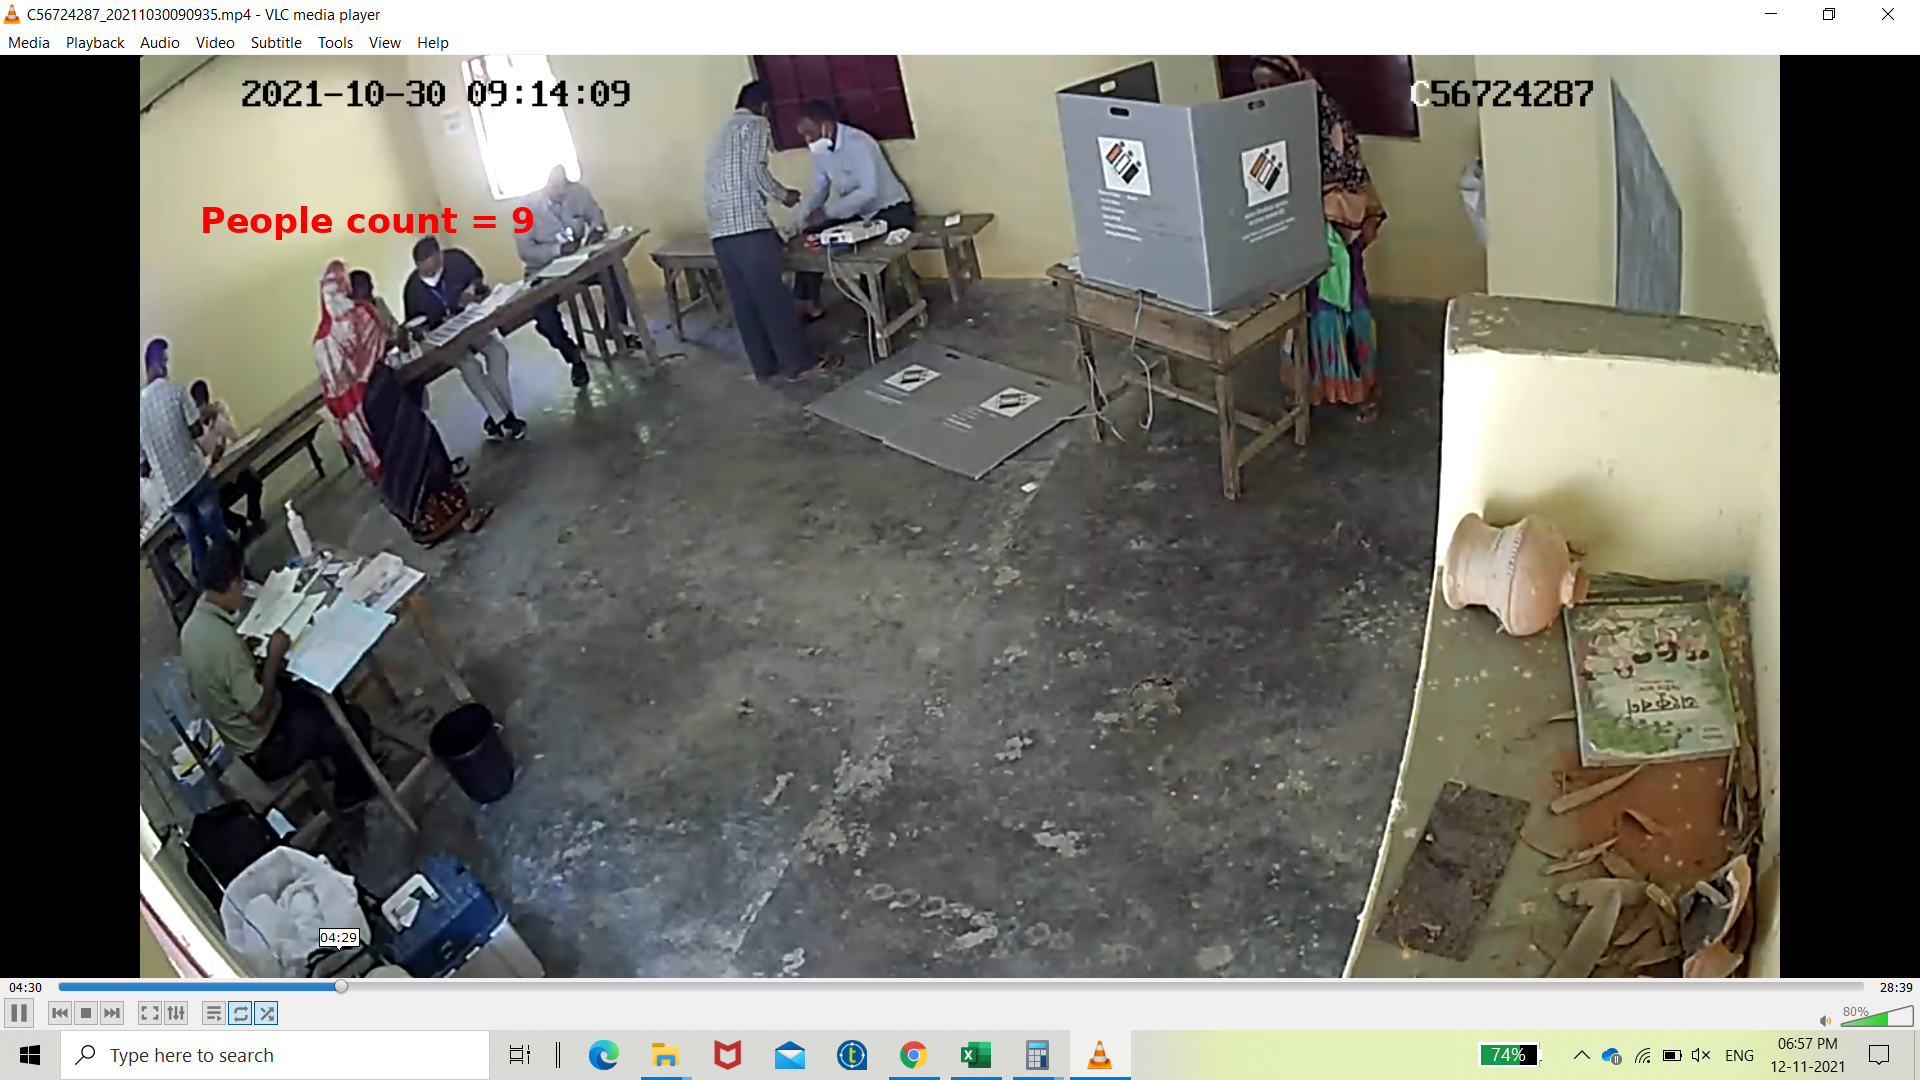

In [18]:
# Note: this image is place holder until we get some outside the polling station images from SmartStream
outImage = 'Screenshot (27).png'
#outImage = img
confidenceLeavel = 70
peopleWaitingOutside(outImage, confidenceLeavel)


---
## Stop the running model

In [ ]:
# stop the model so you don't get charged
import boto3
import time


def stop_model(model_arn):

    client=boto3.client('rekognition')

    print('Stopping model:' + model_arn)

    #Stop the model
    try:
        response=client.stop_project_version(ProjectVersionArn=model_arn)
        status=response['Status']
        print ('Status: ' + status)
    except Exception as e:  
        print(e)  

    print('Done...')
    
def main():
    
    model_arn='arn:aws:rekognition:us-west-2:406078665760:project/SmartStream-evm-custom-label-Dec2021/version/SmartStream-evm-custom-label-Dec2021.2021-12-21T13.46.11/1640119571232'
    stop_model(model_arn)

if __name__ == "__main__":
    main() 